In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.optimize import curve_fit
from collections import defaultdict
from IPython.display import clear_output

In [3]:
def loading_bar(place, size):
    count = int((float(place)/size) * 100)
    if place<=size:
        print(("=" * count) + ("_" * (100-count)), "{}/{}".format(place,size))
    else:
        print(("=" * count) + ("_" * (100-count)), "Done")

In [4]:
def test_digraph(G_func, param, start, interval, iterations=100):
    k_incr = defaultdict(list)

    for i in range(iterations):
        clear_output(wait=True)
        loading_bar(i, iterations)
        G = G_func(*param)
        for n in range(start+1):
            # get neighbors of in edges
            in_neighbors = [ f for f,t in G.in_edges(n) ]
            # find the current degree and how many new nodes attach to it
            old_n = [ v for v in in_neighbors if v <= start ]
            new_n = [ v for v in in_neighbors if v in range(start, start+interval)]
            k_incr[len(old_n)].append(len(new_n))
            
    clear_output(wait=True)
    loading_bar(iterations+1, iterations)
    return k_incr

In [5]:
def test_graph(G_func, param, start, interval, iterations=100):
    k_incr = defaultdict(list)

    for i in range(iterations):
        clear_output(wait=True)
        loading_bar(i, iterations)
        G = G_func(*param)
        for n in range(start+1):
            # get neighbors of in edges
            neighbors = [ f for f in G[n] ]
            # find the current degree and how many new nodes attach to it
            old_n = [ v for v in neighbors if v <= start ]
            new_n = [ v for v in neighbors if v in range(start, start+interval)]
            k_incr[len(old_n)].append(len(new_n))
           
    clear_output(wait=True)
    loading_bar(iterations+1, iterations)
    return k_incr

In [6]:
def model_stats(k_incr):
    k_avg = [ (k,sum(v)/float(len(v))) for k,v in k_incr.items() ]
    k_avg.sort()
    
    x = np.array([ k for k,v in k_avg ])
    y = [ v for k,v in k_avg ]
    y_pr = [ val/sum(y) for val in y ]
    
    fig, axs = plt.subplots(1,1, figsize=(5,5))
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y_pr)
    axs.plot(x, intercept + slope*x)
    axs.scatter( x, y_pr )
    axs.set_title('Degree vs. Attachment Rate', fontsize=20)
    axs.set_xlabel('Degree (k)', fontsize=15)
    axs.set_ylabel(r'Attachment Rate ( P(k $\rightarrow$ k+1) )', fontsize=15)
    
    return slope, intercept, r_value, p_value, std_err

In [21]:
def plotDegsDist(Deg, alpha=None, max_x=200):
    #Deg = [ d for _,d in degrees]
    counts = [ (i, float(Deg.count(i))/len(Deg)) for i in range(1, max(Deg)) if Deg.count(i) ]
    x,y = zip(*counts)

    def func_powerlaw(x, m):
        return x**m

    target_func = func_powerlaw

    if alpha==None:
        p0 = [-2.5]
        popt, pcov = curve_fit(func_powerlaw, x, y, maxfev=2000)
        print(popt)

        plt.loglog(x, target_func(x, *popt), 'r--', label='Best Fit')
    else:
        plt.loglog(range(1,max_x), [ val**alpha for val in range(1,max_x) ], 'r--')
    plt.loglog(x,y, 'co', label='Recorded')
    plt.xlabel('InDegree (k_in)', fontsize=15)
    plt.ylabel('Pr(k_in)', fontsize=15)
    plt.title('In Degree Distribution (loglog)', fontsize=20)
    plt.legend()
    plt.show()

In [8]:
def plotDegsCCDF(kis):
    # tabulate and display the CCDF Pr(K>=k)
    kmax    = max(kis)

    counts, bins = np.histogram(kis, bins=[i for i in range(kmax+2)], density=True)
    cumcounts = np.cumsum(counts)
    cumcounts = np.insert(cumcounts,0,0)
    plt.loglog(bins[1:-1], 1-cumcounts[1:-1], 'rs', alpha=0.5)
    plt.xlabel('Degree, k')
    plt.ylabel('Pr(K>=k)')
    plt.title('CCDF')
    plt.show()

In [9]:
def plotDegsStat(graph_func, param, iterations=1000, digraph=False, alpha=None, max_x=200):
    
    degrees = []
    
    for i in range(iterations):
        clear_output(wait=True)
        loading_bar(i, iterations)
        
        test_G = graph_func(*param)
        if digraph:
            degrees.extend( [ d for _,d in test_G.in_degree() ] )
        else:
            degrees.extend( [ d for _,d in test_G.degree() ] )
    
    clear_output(wait=True)
    loading_bar(iterations+1, iterations)
    plotDegsDist(degrees, alpha=alpha, max_x=max_x)
    plotDegsCCDF(degrees)

# Price Model

In [7]:
def price_model(size, C=3, alpha=1.5):
    # create DiGraph and seed network to create price model from
    G = nx.DiGraph()
    G.add_edge(1,0)
    
    # likelyhood to chose uniform random or proportional to in-degree
    weight = float(C)/(C + alpha)
    
    # Attach nodes following price's model
    # https://en.wikipedia.org/wiki/Price%27s_model
    for i in range(len(G),size):
        r = np.random.random() 

        if r < weight:
            # select based on in-degree
            sel_edge_index = np.random.choice(len(G.edges)) 
            sel_edge = list(G.edges())[sel_edge_index]
            node_sel = sel_edge[1]
        else:
            # select based on uniform random
            node_sel = np.random.choice(G.nodes)

        G.add_edge(i, node_sel)
    
    return G

('====================================================================================================', 'Done')


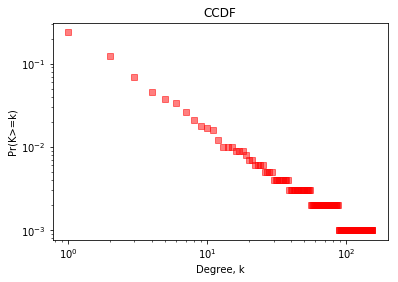

('Correlation: ', 0.9980323834518998)


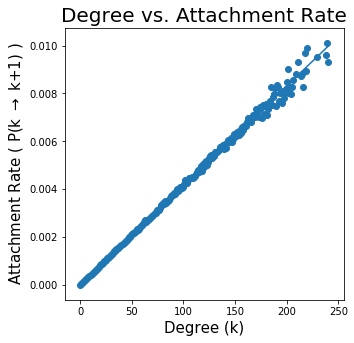

In [10]:
# Graph parameters
size = 1000
params = [size]

# Test parameters
interval = 500
start = 500
iterations = 10000

k_incr = test_digraph(price_model, params, start, interval, iterations)

slope, intercept, r_value, p_value, std_err = model_stats(k_incr);
print("Correlation: ", r_value)

('=====================================================================================================', 'Done')
[-2.92501617]


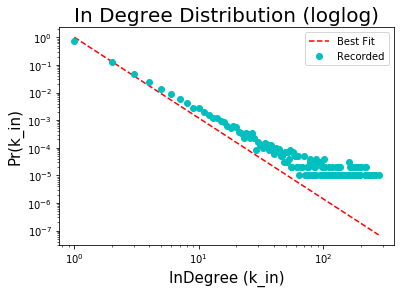

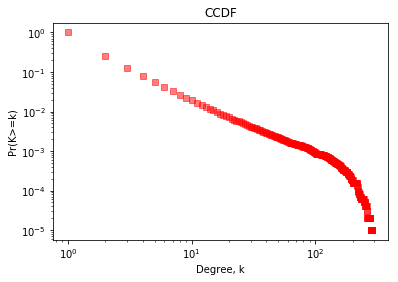

In [189]:
plotDegsStat(price_model, [1000], 100)

# Barabasi-Albert
 Networkx Built-In

('====================================================================================================', 'Done')


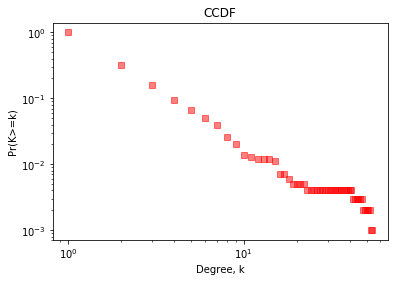

('Correlation: ', 0.9826457315993279)


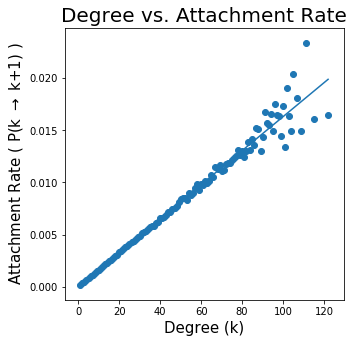

In [22]:
# Graph parameters
size = 1000
m = 1
params = [size, m]

# Test parameters
interval = 500
start = 500
iterations = 10000

k_incr = test_graph(nx.barabasi_albert_graph, params, start, interval, iterations)

slope, intercept, r_value, p_value, std_err = model_stats(k_incr);
print("Correlation: ", r_value)

('=====================================================================================================', 'Done')
[-2.53588337]


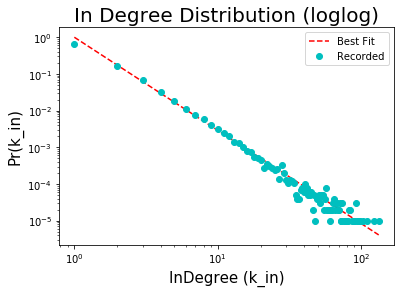

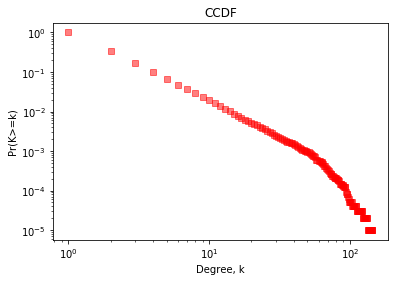

In [190]:
plotDegsStat(nx.barabasi_albert_graph, [1000,1], 100)

Personal Implementation

In [118]:
def barabasi_albert_model(size):
    G = nx.Graph()
    G.add_edge(0,1)

    for i in range(len(G),size):
        k_sum = 2*G.number_of_edges()
        
        prob = [ float(k)/k_sum for n,k in G.degree() ]  

        sel_node = np.random.choice(G.nodes(), p=prob)
        G.add_edge(i, sel_node)
        
    return G

('====================================================================================================', 'Done')


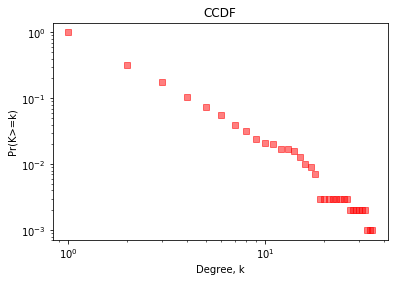

('Correlation: ', 0.9789499007943216)


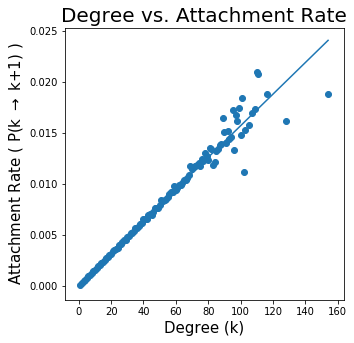

In [13]:
# Graph parameters
size = 1000
params = [size]

# Test parameters
interval = 500
start = 500
iterations = 10000

k_incr = test_graph(barabasi_albert_model, params, start, interval, iterations)

slope, intercept, r_value, p_value, std_err = model_stats(k_incr);
print("Correlation: ", r_value)

('=====================================================================================================', 'Done')
[-2.54107919]


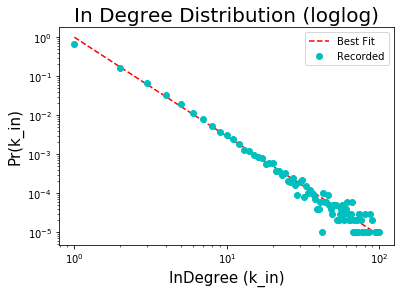

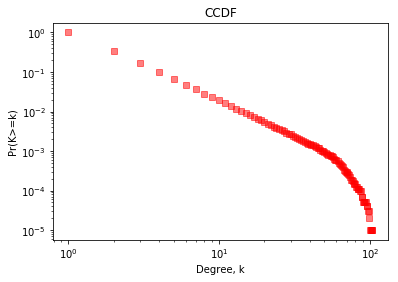

In [191]:
plotDegsStat(barabasi_albert_model, [1000], 100)

# Uniform Random

In [126]:
def uniform_random_model(size):
    G = nx.Graph()
    G.add_edge(0,1)
    
    for i in range(len(G),size):
        # len(G) == i
        sel_node = np.random.randint(0,i)
        G.add_edge(i, sel_node)
        
    return G

('====================================================================================================', 'Done')


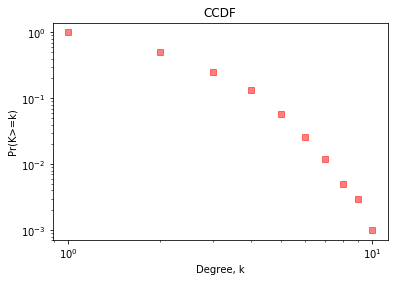

('Correlation: ', -0.5234142814819492)


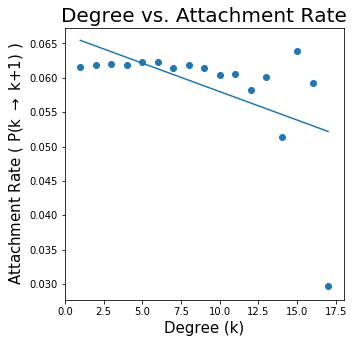

In [15]:
# Graph parameters
size = 1000
params = [size]

# Test parameters
interval = 500
start = 500
iterations = 10000

k_incr = test_graph(uniform_random_model, params, start, interval, iterations)

slope, intercept, r_value, p_value, std_err = model_stats(k_incr);
print("Correlation: ", r_value)

('=====================================================================================================', 'Done')
[-2.01865617]


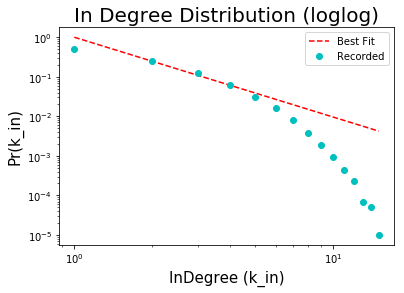

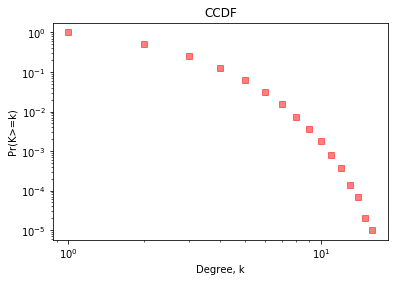

In [192]:
plotDegsStat(uniform_random_model, [1000], 100)

# Time Model

In [129]:
def time_model(size):
    G = nx.Graph()
    G.add_edge(0,1)
    
    for i in range(len(G), size):
        nodes = G.nodes()
        nodes_len = len(nodes)
        nodes_sum = sum(nodes)
        
        # randomly select node
        sel_node_prob = np.random.random()
        lower_bound = 0
        sel_node = -1
        
        for x in nodes:
            bucket_size = (nodes_len-x)/float(nodes_sum+i)
            upper_bound = lower_bound + bucket_size
            if sel_node_prob < upper_bound and sel_node_prob >= lower_bound:
                sel_node = x
            lower_bound = upper_bound
        
        G.add_edge(i, sel_node)
    
    return G

('====================================================================================================', 'Done')


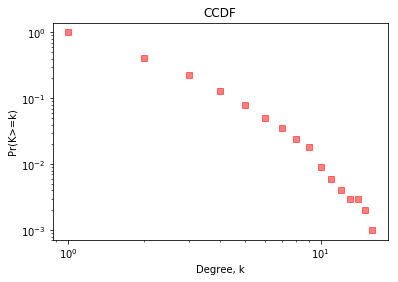

('Correlation: ', 0.3405310601745511)


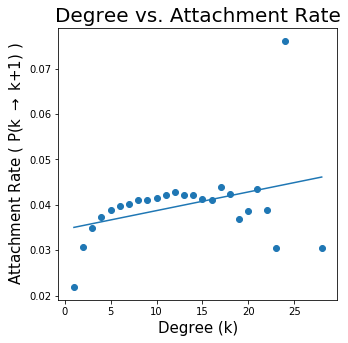

In [17]:
# Graph parameters
size = 1000
params = [size]

# Test parameters
interval = 500
start = 500
iterations = 10000

k_incr = test_graph(time_model, params, start, interval, iterations)

slope, intercept, r_value, p_value, std_err = model_stats(k_incr);
print("Correlation: ", r_value)

('=====================================================================================================', 'Done')


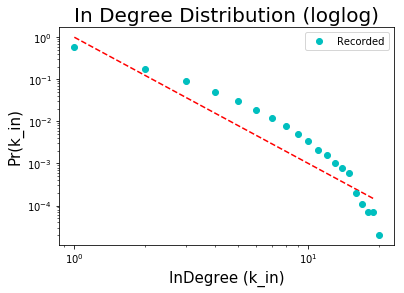

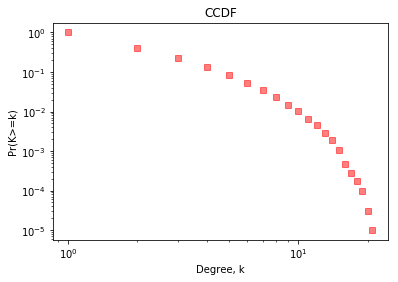

In [214]:
plotDegsStat(time_model, [1000], 100, alpha=-3, max_x=20)

# Geodesic Distance

In [131]:
def mean_geodesic_model(size):
    G = nx.Graph()
    G.add_edge(0,1)
    dist = np.zeros([size, size])
    avg = np.zeros(size)
    
    dist[1][0] = 1
    dist[0][1] = 1
    
    avg[0] = 1
    avg[1] = 1
    
    for i in range(len(G), size):
        mean_geo_dist = [ float(x)/(i-1) for x in avg[:i] ]
        mean_geo_sum = sum(mean_geo_dist)
        
        prob = [ float(x)/mean_geo_sum for x in mean_geo_dist ]
        sel_node = np.random.choice(G.nodes(), p=prob)
        G.add_edge(i, sel_node)
        dist[i,:i] = dist[sel_node,:i]+1
        dist[:i,i] = dist[:i,sel_node]+1
        
        avg[i] = avg[sel_node]+i
        for j in range(i):
            avg[j] = avg[j] + dist[j,sel_node] + 1
    
    #print(avg)
    #print(dist)
    return G

('====================================================================================================', 'Done')


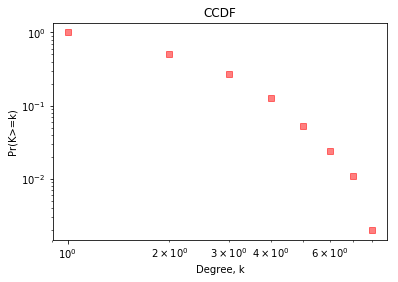

('Correlation: ', -0.6832144700465157)


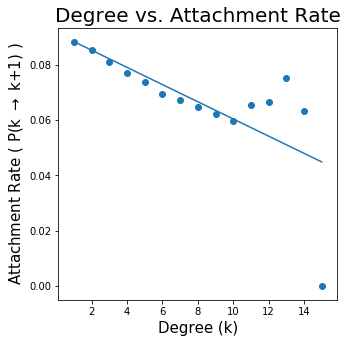

In [19]:
# Graph parameters
size = 1000
params = [size]

# Test parameters
interval = 500
start = 500
iterations = 10000

k_incr = test_graph(mean_geodesic_model, params, start, interval, iterations)

slope, intercept, r_value, p_value, std_err = model_stats(k_incr);
print("Correlation: ", r_value)

('==============================================================================================================', 'Done')
[-1.99879734]


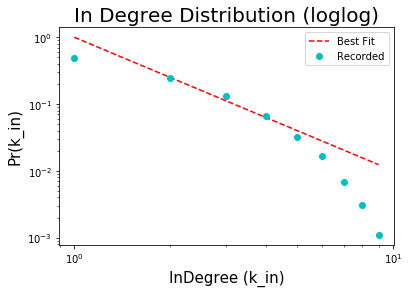

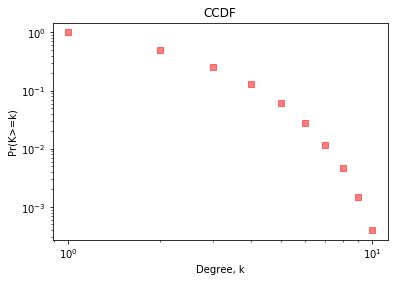

In [194]:
plotDegsStat(mean_geodesic_model, [1000], 10)

In [133]:
def inverse_mean_geodesic_model(size):
    G = nx.Graph()
    G.add_edge(0,1)
    dist = np.zeros([size, size])
    avg = np.zeros(size)
    
    dist[1][0] = 1
    dist[0][1] = 1
    
    avg[0] = 1
    avg[1] = 1
    
    for i in range(len(G), size):
        mean_geo_dist = [ float(x)/(i-1) for x in avg[:i] ]
        mean_geo_sum = sum(mean_geo_dist)
        
        inverse_prob = [ mean_geo_sum/float(x) for x in mean_geo_dist ]
        prob_sum = sum(inverse_prob)
        # Normalize
        prob = [ float(x)/prob_sum for x in inverse_prob]
        
        sel_node = np.random.choice(G.nodes(), p=prob)
        G.add_edge(i, sel_node)
        dist[i,:i] = dist[sel_node,:i]+1
        dist[:i,i] = dist[:i,sel_node]+1
        
        avg[i] = avg[sel_node]+i
        for j in range(i):
            avg[j] = avg[j] + dist[j,sel_node] + 1
    
    #print(avg)
    #print(dist)
    return G

('====================================================================================================', 'Done')


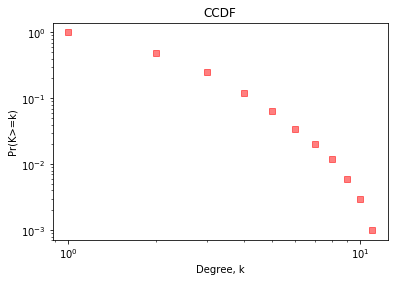

('Correlation: ', 0.2785602654309893)


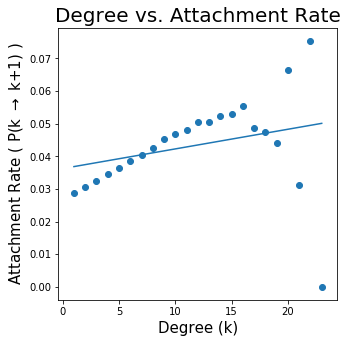

In [21]:
# Graph parameters
size = 1000
params = [size]

# Test parameters
interval = 500
start = 500
iterations = 10000

k_incr = test_graph(inverse_mean_geodesic_model, params, start, interval, iterations)

slope, intercept, r_value, p_value, std_err = model_stats(k_incr);
print("Correlation: ", r_value)

('=====================================================================================================', 'Done')


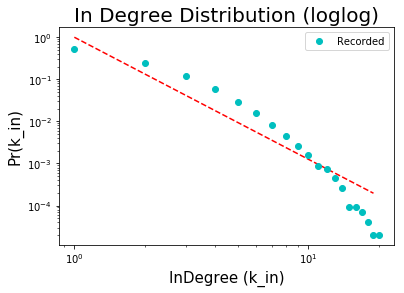

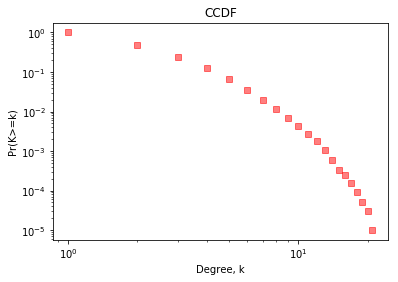

In [211]:
plotDegsStat(inverse_mean_geodesic_model, [1000], 100, alpha=-2.9, max_x=20)

# Triadic Closure

In [10]:
def triadic_closure(size, num_add_edges = 2, p = 0.5):
    #grows a network of 'size' number of nodes
    #adds one node at a time, connecting it to 'num_add_edges' pre-existing nodes based on the following criteria
    #TRIADIC CLOSURE:
    #    close a random triangle with probability p
    G = nx.Graph()
    
    #NEED TO FIGURE OUT HOW TO SET UP BASE GRAPH IF WE HAVE TO ADD UNIQUE EDGES
    G.add_edge(0,1)
    
    for i in range(len(G),size):
        #sets up possibility to close a triangle, this could be determine by something else besides random selection.
        first_sel = np.random.randint(0,i)
        
        #flip a coin, if it's heads, close a triangle, otherwise choose uniformly at random which node to connect to
        if np.random.rand() > p:
            #triadic closure -- connect to the neighbor of first selected node
            second_sel = np.random.choice(list(G.neighbors(first_sel)))
        else:
            #just choose randomly
            second_sel = np.random.randint(0,i) #THERE IS STILL A CHANCE TO JUST HAVE 1 NEW EDGE!
        G.add_edges_from([(i, first_sel), (i, second_sel)])
        
    return G

('=====================================================================================================', 'Done')
('Correlation: ', 0.5852603905898713)


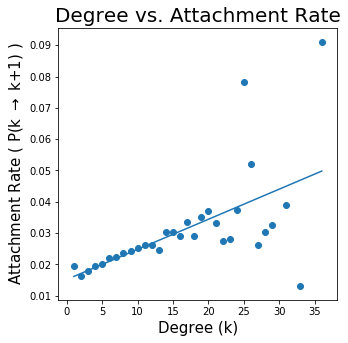

In [12]:
# Graph parameters
size = 1000
params = [size]

# Test parameters
interval = 500
start = 500
iterations = 100

k_incr = test_graph(triadic_closure, params, start, interval, iterations)

slope, intercept, r_value, p_value, std_err = model_stats(k_incr);
print("Correlation: ", r_value)

('=====================================================================================================', 'Done')


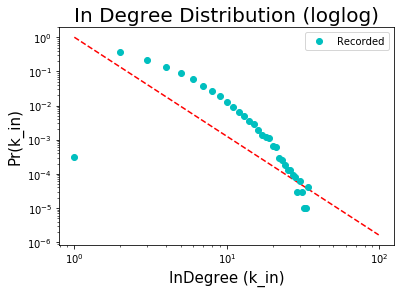

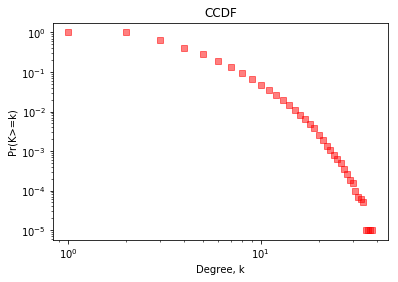

In [23]:
plotDegsStat(triadic_closure, [1000], 100, alpha=-2.9, max_x=100)

# Local Clustering Coefficient

In [24]:
##WORK IN PROGRESS, WILL FINISH THIS TOMORROW.

def get_probs(G, i_neighbors, num_nodes):
    # function to get the probabilities to choose a node i for the new incoming node 
    # this is given by lcc = 2*num_neighbors_connected/(num_neighbors*(num_neighbors-1))
    # i_neighbors is assumed to be a list of node i's neighbors
    
    probs = []
    lcc_sum = 0
    for i in G.nodes():
        i_neighbors = G.neighbors(i)
        total_num_neighbors = 0
        num_neighbors_connected = 0
        for node in i_neighbors:
            total_num_neighbors += 1 #i doubt this will save much time, but better than no time save i supposed
            for node_neighbor in G.neighbors(node):
                if node_neighbor in i_neighbors:
                    num_neighbors_connected += 1
        if total_num_neighbors <= 1:
            #would cause a division by 0 error
            lcc = 0
        else:
            lcc = (num_neighbors_connected+num_neighbors_connected)/(total_num_neighbors*(total_num_neighbors-1))
        lcc_sum += lcc+1
        probs.append((lcc+1)/(num_nodes+num_nodes)) #this isn't going to work because the clustering coefficients will not add to 1
    
    #lcc_sum is the numerator for the probability count
    #the denominator is 2*num_nodes. This will give a sum of probabilities that is less than 1.
    #we can then scale the probabilities such that they add up to 1
    lcc1/denom + lcc2/denom + lcc3/denom + ... + lcc4/denom = 1
    [(calc_lcc(G, list(G.neighbors(i)), num_nodes)+1)/num_nodes for i in G.nodes()]

def uniform_local_clustering_coef(size, num_add_edges = 2):
    #choose 2 nodes uniformly at random, and connect to them. Does this create a scale-free network?
    #grows a network of 'size' number of nodes
    #adds one node at a time, connecting it to 'num_add_edges' pre-existing nodes based on the following criteria
    #LOCAL CLUSTERING COEFFICIENT:
    #    more likely to choose nodes that have a high local clustering coefficient
    G = nx.Graph()
    
    #NEED TO FIGURE OUT HOW TO SET UP BASE GRAPH IF WE HAVE TO ADD UNIQUE EDGES
    G.add_edge(0,1)
    num_nodes = 2
    #CAUTION: THIS DICT WILL BE HUGE DEPENDING ON 'size'
    #dictionary to keep track of local clustering coefficients. Initially this is 0 (I think, should probably check that)
    lccDict = {0: 0, 1: 0}
    
    #set up probabilities:
    probs = [(calc_lcc(G, list(G.neighbors(i)), num_nodes)+1)/ for i in G.nodes()] #these are the weights, let's normalize them with add-1 smoothing
    print(probs)
    for i in range(num_nodes,size):
        probs = get_probs(G) 
        print(probs)
        first_sel = np.random.choice(range(num_nodes), size = 2, p = probs)
        G.add_edges_from([(i, first_sel[0]), (i, first_sel[1])])
        num_nodes += 1
        
    return G

uniform_local_clustering_coef(5)

SyntaxError: invalid syntax (<ipython-input-24-a1d0f50ee186>, line 30)

In [ ]:
print(np.random.choice(list({1: 0, 2: 0}.keys())))